In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
Titles_Relabeled = pd.read_csv('Titles_English_Relabeled.csv')

In [3]:
Titles_Relabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300359 entries, 0 to 300358
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            300359 non-null  int64 
 1   EAN                   300359 non-null  int64 
 2   Title                 300359 non-null  object
 3   Ingram Category Code  298878 non-null  object
 4   MJR BISAC             300359 non-null  object
 5   BISAC                 300359 non-null  object
 6   Annotation Text       300359 non-null  object
 7   Category              300359 non-null  int64 
 8   language_detected     300359 non-null  object
dtypes: int64(3), object(6)
memory usage: 20.6+ MB


In [4]:
Titles_Relabeled = Titles_Relabeled.drop('Unnamed: 0', axis=1)
Titles_Relabeled['EAN'] = Titles_Relabeled['EAN'].astype(str)

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1000, ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(Titles_Relabeled['Annotation Text']).toarray()
labels = Titles_Relabeled.Category
features.shape

(300359, 3830)

In [6]:
Titles_train, Titles_test = train_test_split(Titles_Relabeled, random_state=42)

In [7]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MaxAbsScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

# Initialize the MaxAbsScaler
scaler = MaxAbsScaler()

# Fit on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Just transform the test data
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model on the scaled data
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

# Get the predicted labels and probabilities on the scaled test data
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy*100:.2f}%')

# Create a dataframe with the predicted labels and maximum probabilities (confidence scores)
results_df = pd.DataFrame({
    'Predicted Category': y_pred,
    'Confidence Score': np.max(y_pred_proba, axis=1)
}, index=Titles_test.index)  # use the same indices as in Titles_test

# Add the 'Annotation Text' column to the results
results_df = Titles_test[['EAN', 'Title', 'Annotation Text', 'MJR BISAC']].join(results_df)

# Print the results
print(results_df)

C:\Users\Pupnsuds90\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model accuracy: 72.57%
                  EAN                                              Title  \
272607  9781911413790  Dancing Bear                                  ...   
40303   9781646792375  Life of General Ulysses S. Grant: Containing a...   
172631  9781376644197  Adam's Illustrated Guide to Rye (with map): Wi...   
286961  9781649791696  Angela's Letter                               ...   
191935  9781377360799  Memoirs of a Professional Lady Nurse          ...   
...               ...                                                ...   
182491  9781614938200  Feeling Special                               ...   
23941   9781786234254  My Father's People                            ...   
2172    9781636171784  Every Kid's Guide to Coping with Childhood Tra...   
114632  9781647185596  Nevermore...                                  ...   
153901  9781608741144  Sea Pictures, Op.37: Vocal score (Urtext)     ...   

                                          Annotation Text MJR BI

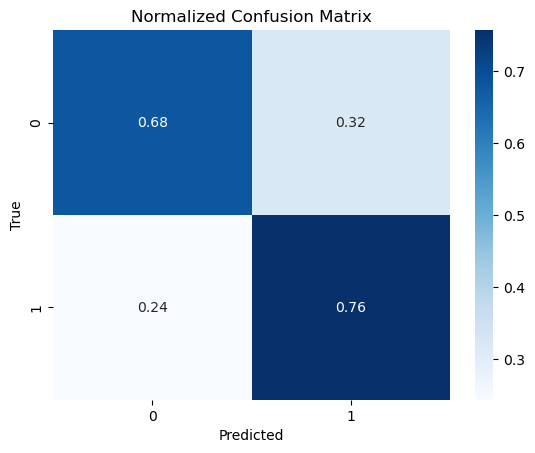

In [8]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:")
print(cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = cv_scores.mean()

print(f"\nMean Cross-Validation Score: {mean_cv_score:.2f}")

C:\Users\Pupnsuds90\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MemoryError: Unable to allocate 5.14 GiB for an array with shape (180215, 3830) and data type float64

In [11]:
results_df.to_csv('Model_3.csv')